In [1]:
import torch
import numpy as np
import random
import timeit
from os.path import exists
import pickle

from prepared_models import pretrained_model
from preparing_datas import data
from gsa_executing import GSA_executing
from utils import print_norm_and_accuracy, plot_results, calculate_result, make_path_or_model_name
from gsa_arguments import arguments

parser = arguments()
args = parser.parse_args()

torch.manual_seed(12)
torch.cuda.manual_seed_all(12)
torch.backends.cudnn.deterministic = True

np.random.seed(12)
random.seed(12)

# use cuda if it is available
if torch.cuda.device_count() != 0:
    device = torch.device('cuda:0')
else :
    device = torch.device('cpu')


# preparing vit_small_16_224 and imagenet dataset

In [ ]:
# best batch 20
parser = arguments()
args = parser.parse_args()
args.model_type = 'vits16'
args.dataset_type = 'imagenet'

args.num_data = 100

# load model
net = pretrained_model(model_type= args.model_type ,path_or_model_name = make_path_or_model_name(args.model_type))

# load data
attack_data_test,attack_label_test = data(net, dataset_type= args.dataset_type)

attack_data_test = attack_data_test[:args.num_data]
attack_label_test = attack_label_test [ : args.num_data]

# Notice:
## This Result is according to another test data selection that is different from the paper

batch attack : 1
number of attacked images :  15
chanage lambda1 : 0.06
number of attacked images :  29
chanage lambda1 : 0.036
number of attacked images :  34


batch attack : 2
number of attacked images :  17
chanage lambda1 : 0.06
number of attacked images :  26
chanage lambda1 : 0.036
number of attacked images :  33
chanage lambda1 : 0.022
number of attacked images :  34


batch attack : 3
number of attacked images :  14
chanage lambda1 : 0.06
number of attacked images :  30
chanage lambda1 : 0.036
number of attacked images :  31
chanage lambda1 : 0.022
number of attacked images :  31
chanage lambda1 : 0.02
number of attacked images :  31
chanage zita_inf : 0.03
number of attacked images :  31
chanage lambda1 : 0.06
number of attacked images :  31
chanage lambda1 : 0.036
number of attacked images :  31
chanage lambda1 : 0.022
number of attacked images :  31
chanage lambda1 : 0.02
number of attacked images :  31
chanage zita_inf : 0.045
number of attacked images :  31
chanage lambda

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


number of attacked images :  32


    num_blocks: 0 
    norm1_mean: 14.245       norm1_std: 12.659       norm1_max: 61.812 
    norm2_mean: 0.472       norm2_std: 0.209       norm2_max: 1.126 
    *linf_mean: 0.02       linf_std: 0.008       linf_max: 0.102 
    *norm0_mean: 807.23       norm0_std: 765.168       norm0_max: 3797.0 
    *number_pert_mean: 616.27       number_pert_std: 555.578       number_pert_max: 2723.0 
     ****accuracy*****: 1.0 

   total Time (min) :  65.329    time per image (sec) : 39.197


<Figure size 432x288 with 0 Axes>

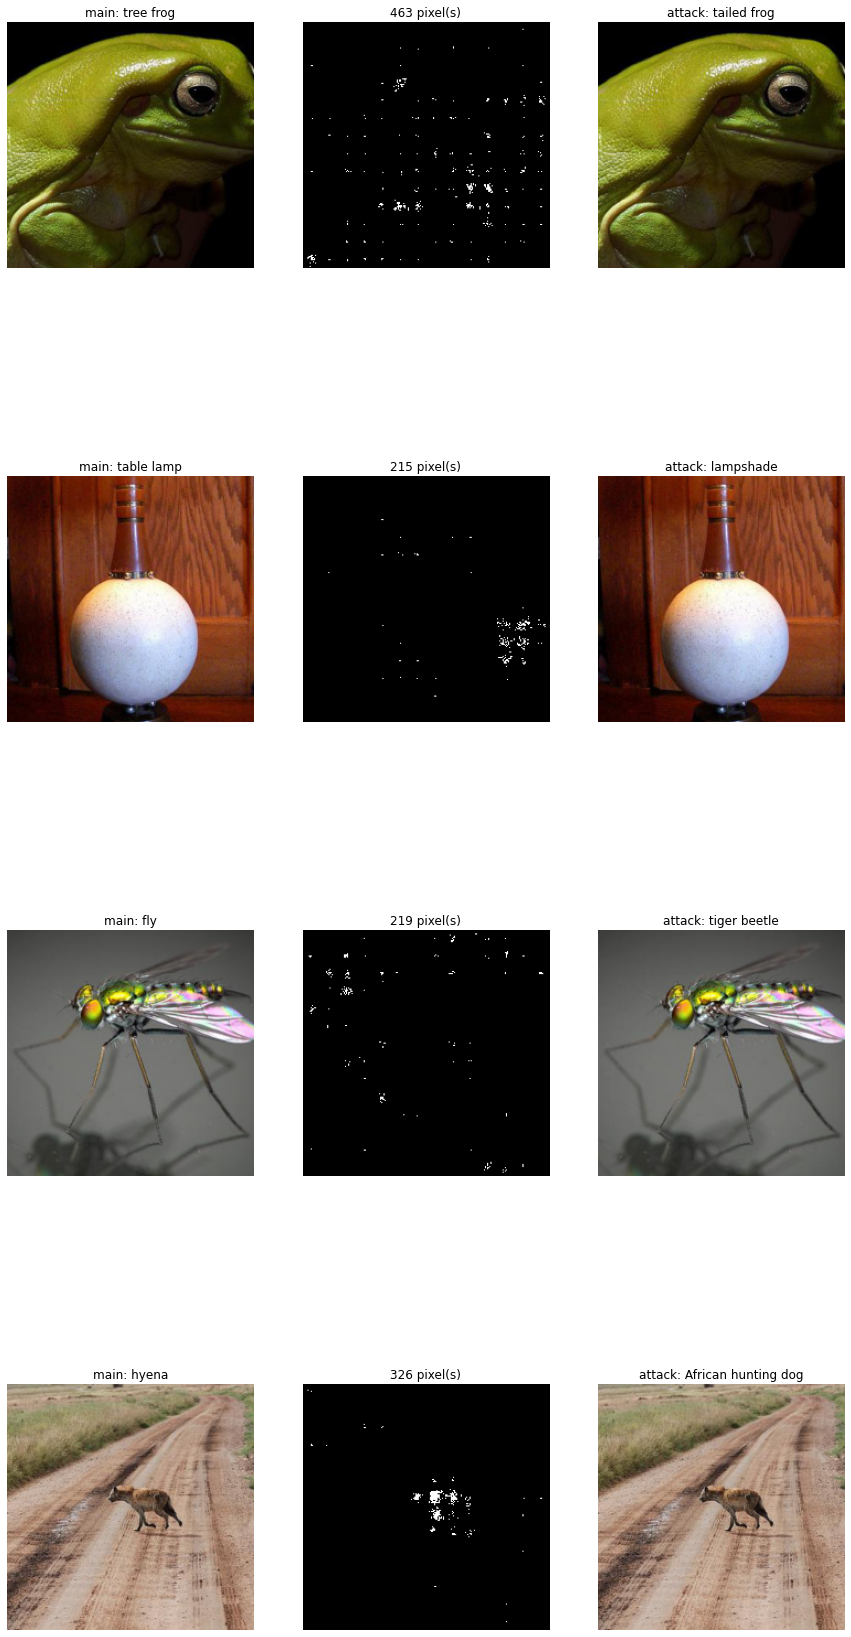

In [4]:
# Untargeted
parser = arguments()
args = parser.parse_args()
args.model_type = 'vits16'
args.dataset_type = 'imagenet'

# Setting hyperparameters according to the paper
args.num_data = 100
last =100
batch = 34
args.attack_batch = 34
args.lambda1 = 0.1
args.zita_inf = 0.02
args.zita_inf_s = 1.5
args.lambda1_s = 0.6

# Initialization
adv_deltas = torch.zeros_like(attack_data_test[:last])
adv_acc = torch.ones_like(attack_label_test[:last]).numpy()

start = timeit.default_timer()
k=0

# attacking the model with test dataset
for i in range(0,last,batch):
    k+=1
    print('batch attack :',k)
    adv_deltas_temp, adv_acc_temp = GSA_executing(net, attack_data_test[:last][i:i+batch],attack_label_test[:last][i:i+batch], args) 

    adv_deltas[i:i+batch] = adv_deltas_temp
    adv_acc[i:i+batch] = adv_acc_temp 

stop = timeit.default_timer()
time =stop - start

if all(adv_acc==0) :
    print('****** No attack Result ******')
    result = calculate_result(adv_deltas[:1], adv_acc, time)
else :
    result = calculate_result(adv_deltas[adv_acc == 1], adv_acc, time)

print_norm_and_accuracy(result)

print('   total Time (min) : ', round((time)/60, 3) ,"   time per image (sec) :", round((time) /last, 3)) 

args.plot = True

if args.plot :
    args.number_of_plots = 4
    np = args.number_of_plots 
    outputs = net((attack_data_test[:np]+adv_deltas[:np]).to(device))
    fool_labels = torch.argmax(outputs, 1)
    plot_results(attack_data_test[:np], attack_data_test[:np]+adv_deltas[:np],attack_label_test[:np], fool_labels[:np] ,
                 imagenet_or_cifar10 = args.dataset_type)